## Stochastic Volatility Model

$$
dX_t = \mu dt + \sqrt{Z_t} dW^x_t \\
dZ_t = (\theta + \kappa Z_t) dt + \sigma_z \sqrt{Z_t} dW_t^z
$$

In this example the volatility of the volatility, $\sigma_z$, is held constant as it is challenging to estimate

Priors: 

$$
\theta \sim TruncNorm()  \\
\kappa \sim TruncNorm()
$$

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pfjax as pf
import pfjax.sde as sde

from functools import partial

from pfjax import particle_resamplers as resampler
import pfjax.mcmc as mcmc

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

# needed for local imports in Jupyter:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)

from pmmh import *
from sv_model import * 
from utils import * 

In [3]:
key = random.PRNGKey(100)

_dt = 1
_n_res = 5
n_obs = 500

# parameters: 
_theta = 0.02
kappa = -0.03
sigma_z = 0.18
mu = 0.008

# theta = jnp.array([_theta, kappa, sigma_z, mu])
theta = jnp.array([_theta, kappa, mu])
x_init = jnp.block([[jnp.zeros((_n_res-1, 2))],
                    [jnp.array([2.0, 45.0])]])

volmodel = StochVol(_dt, _n_res, sigma_z=sigma_z)
y_meas, x_state = pf.simulate(volmodel, key, n_obs, x_init, theta)

In [4]:
point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * _n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])

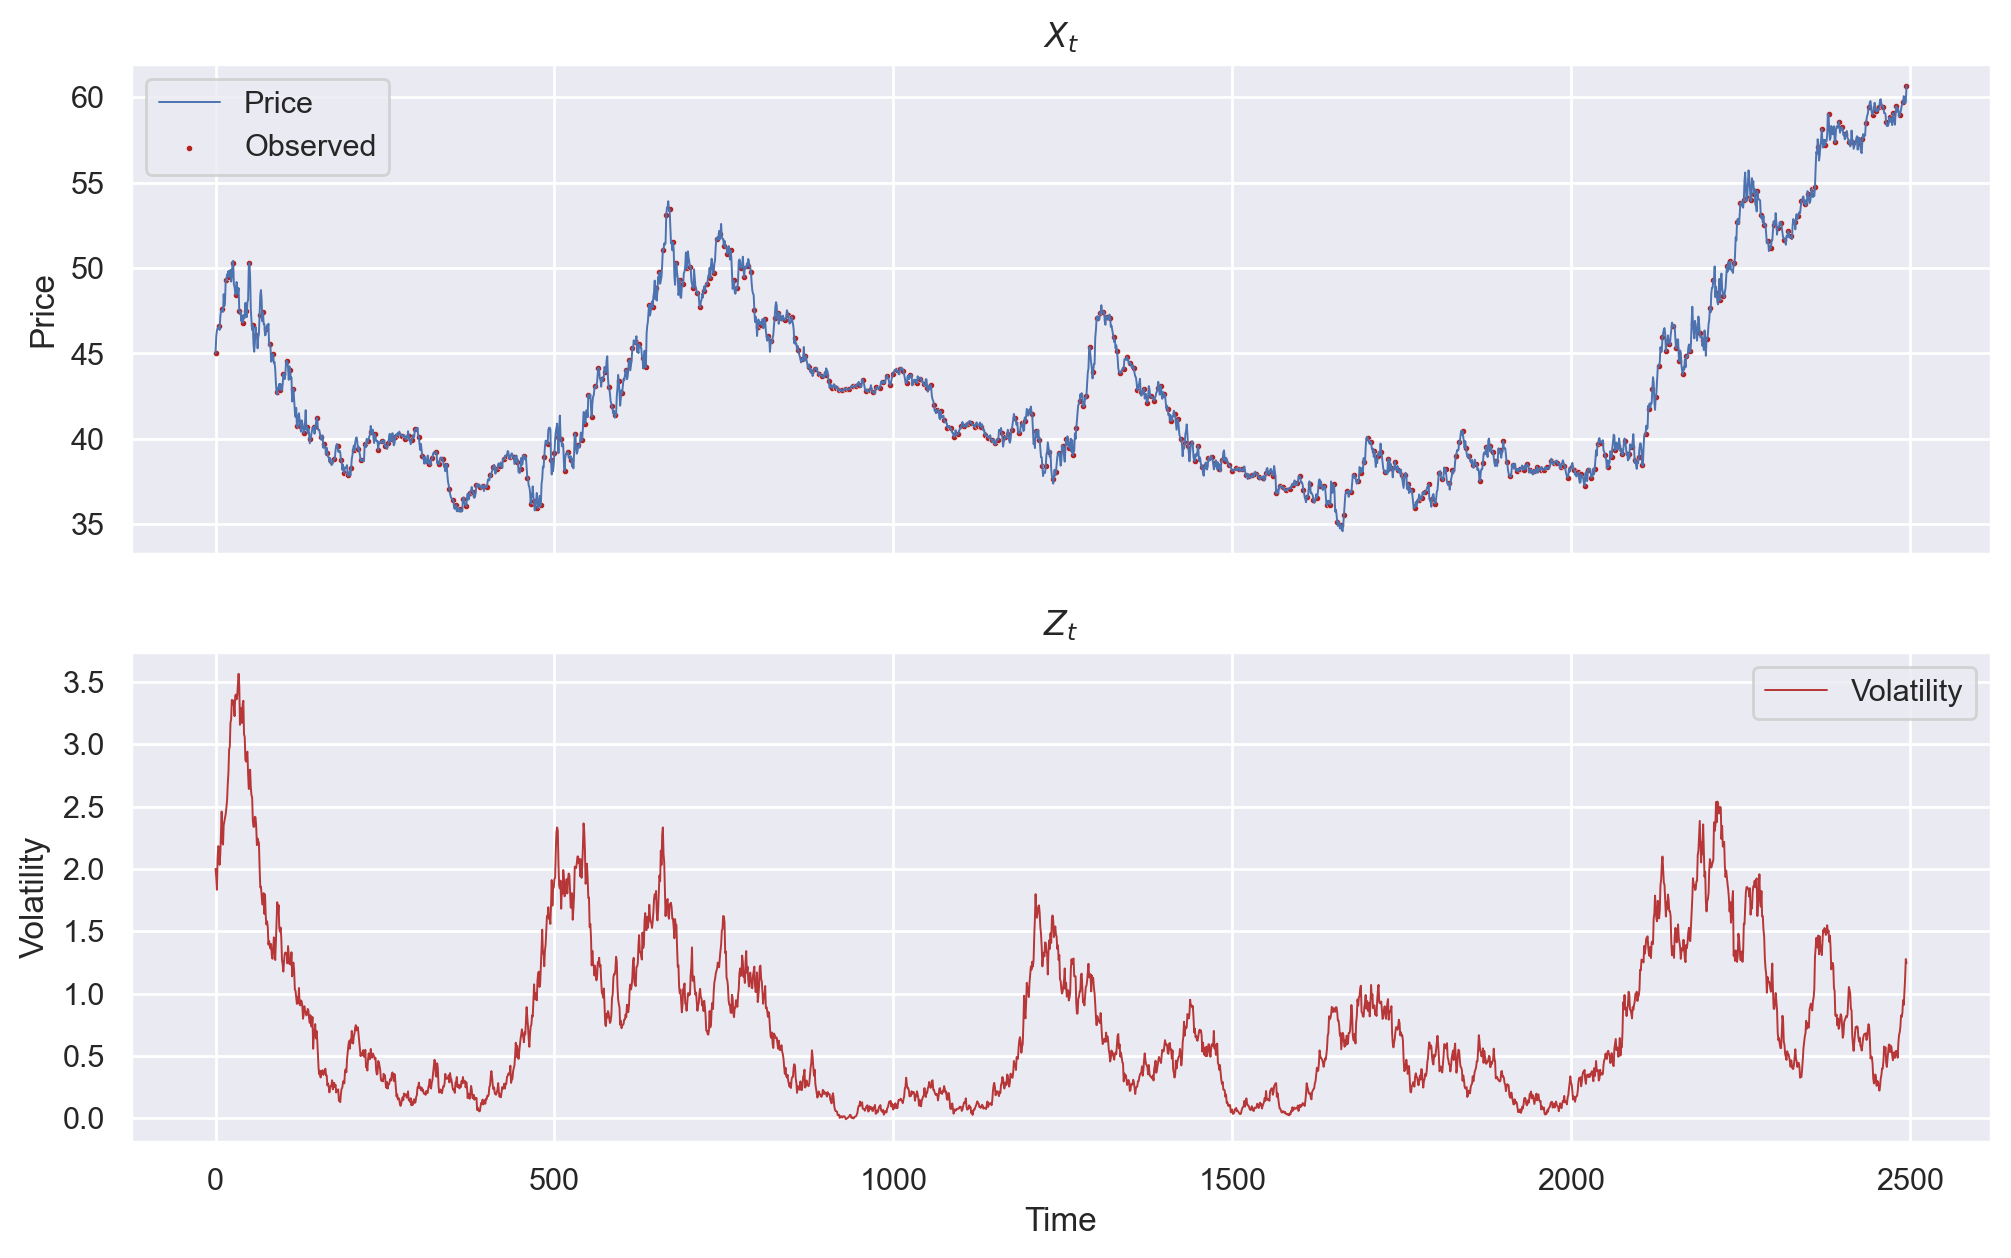

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(data= x_state[..., 1].reshape(_n_res*n_obs, 1)[(_n_res-1):].squeeze(),
             ax = ax[0], linewidth=0.7,
             label = "Price").set(title ="$X_t$", ylabel="Price")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax[0],
                s=5,
                label="Observed").set(title ="$X_t$")

sns.lineplot(data= x_state[..., 0].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze(),
             ax = ax[1], alpha = 0.9, linewidth=0.7, color = "firebrick",
             label = "Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

In [6]:
num_particles = 1000

pf_jit = jax.jit(partial(
    pf.particle_filter,
    model = volmodel,
    key = random.PRNGKey(0),
    y_meas = y_meas,
    theta = theta, #jnp.array([-90, -3.506558, 0.008]),
    history=True
), static_argnames="n_particles")

multinom_pf = pf_jit(n_particles=num_particles)

In [7]:
est_vol_mean = jax.vmap(
    lambda x, w: jnp.average(x, axis=0, weights=pf.utils.logw_to_prob(w)),
    in_axes = (0, 0))(multinom_pf["x_particles"][1:, ..., 0],
                      multinom_pf["logw"][1:, ...])

est_vol_lower = jax.vmap(
    lambda x, logw: x[quantile_index(logw, q=0.025)],
    in_axes = (0, 0))(multinom_pf["x_particles"][1:, ..., 0],
                      multinom_pf["logw"][1:, ...])

est_vol_upper = jax.vmap(
    lambda x, logw: x[quantile_index(logw, q=0.975)],
    in_axes = (0, 0))(multinom_pf["x_particles"][1:, ..., 0],
                      multinom_pf["logw"][1:, ...])

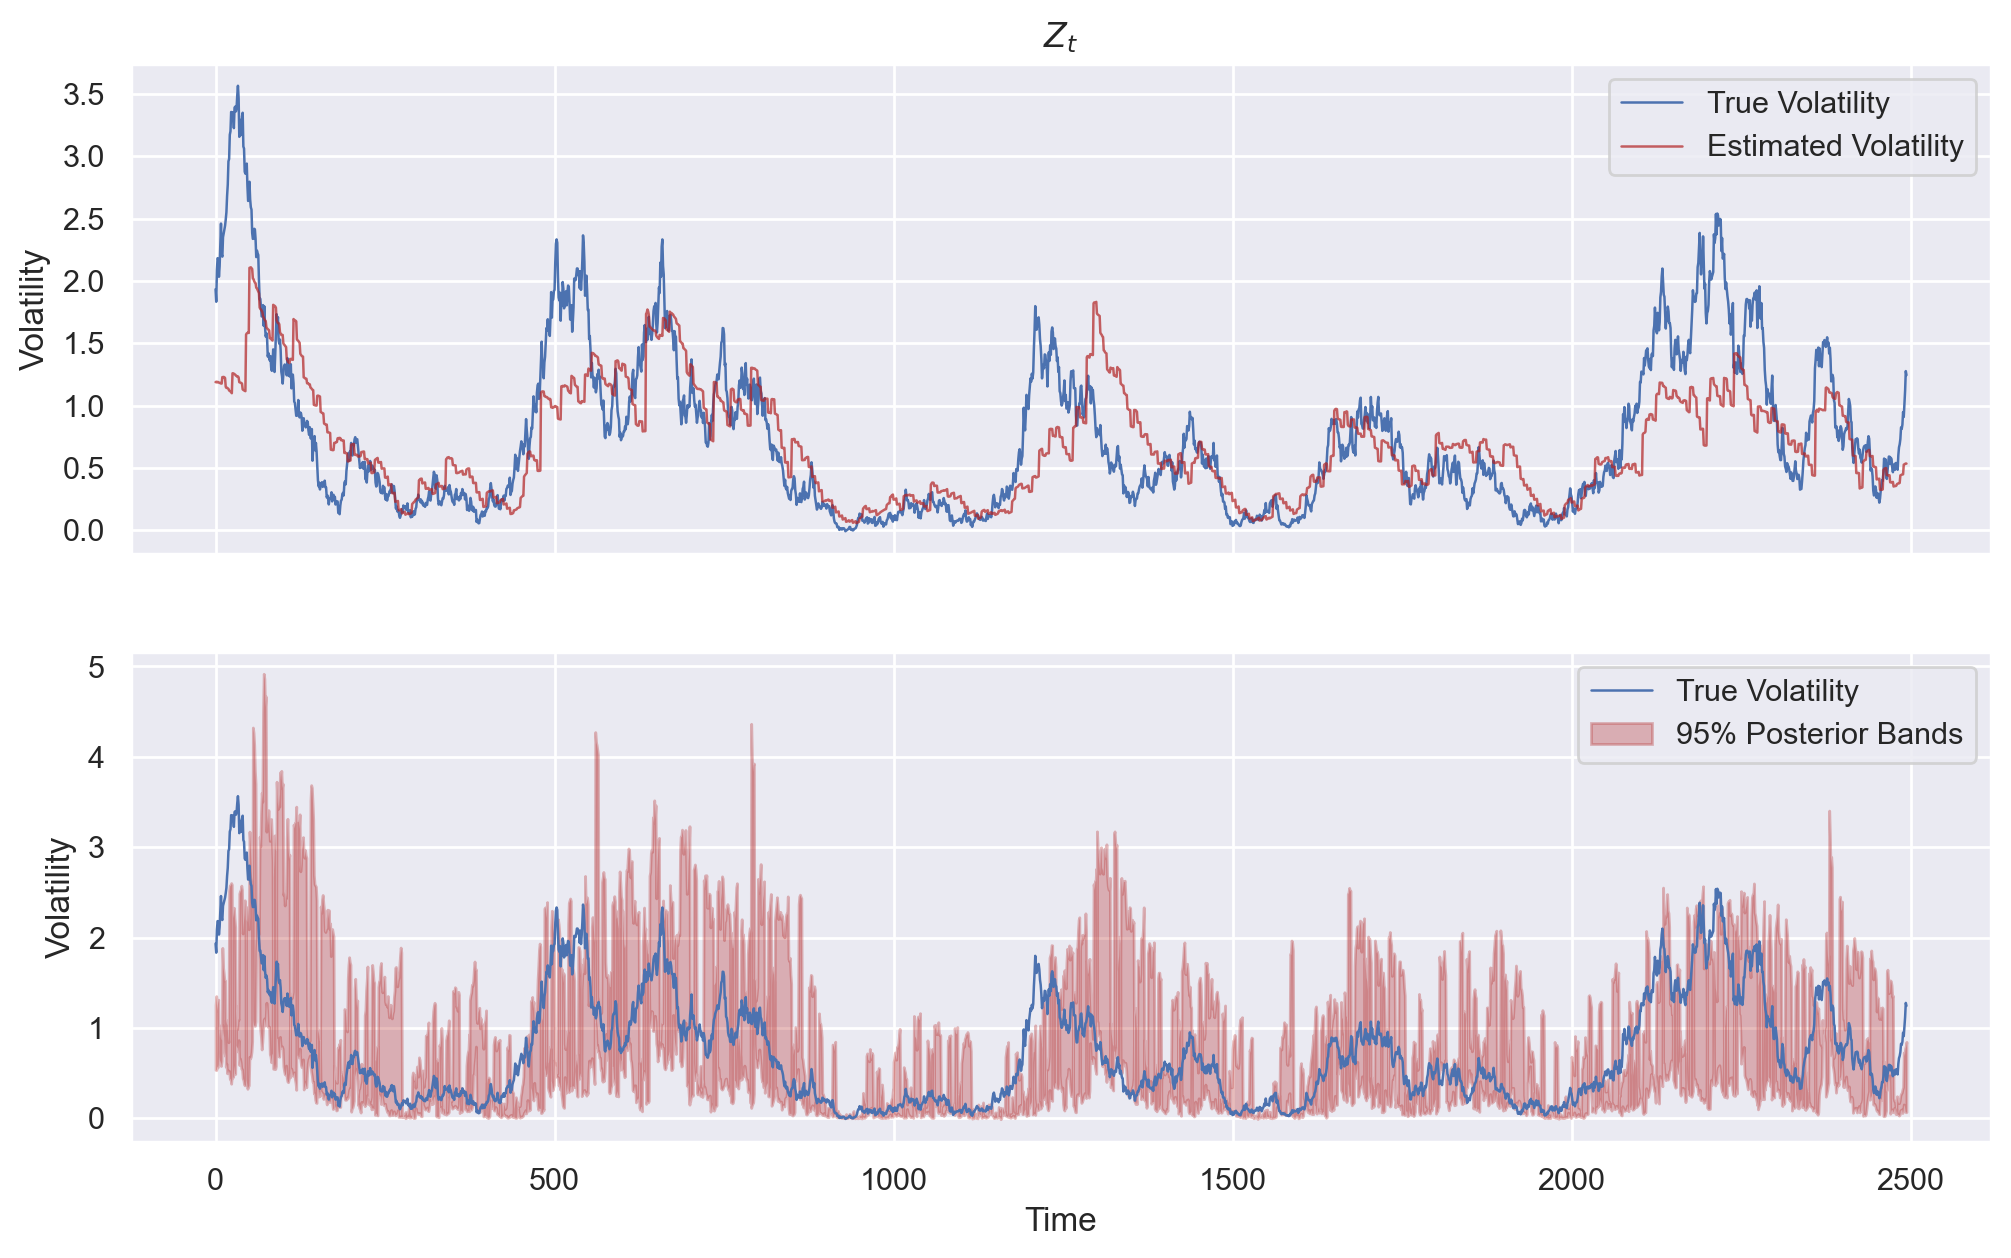

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(
    data = x_state[1:, :, 0].flatten(),
    linewidth = 0.9, ax=ax[0],
    label = "True Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility")
sns.lineplot(data = est_vol_mean.flatten(), 
             color = "firebrick", linewidth = 0.9, 
             alpha = 0.7, ax=ax[0],
             label = "Estimated Volatility")

sns.lineplot(
    data = x_state[1:, :, 0].flatten(), ax=ax[1],
    linewidth=0.9, 
    label = "True Volatility").set(xlabel="Time", ylabel="Volatility")
ax[1].fill_between(
    x = jnp.arange((n_obs-1)*_n_res),
    y1=est_vol_lower.flatten(),
    y2=est_vol_upper.flatten(),
    color = "firebrick",
    label="95% Posterior Bands",
    alpha = 0.3
)
ax[1].legend();

### PMMH

In [9]:
def sv_logprior (theta):
    return 0.0

In [19]:
start = time.perf_counter()
n_particles = 100
n_iter = 2000

#theta_init = jnp.array([0.1, -2., 0.05])
theta_init = theta
rw_sd = jnp.ones(3) * 0.01

key, subkey = jax.random.split(key)
pg_out = pmmh(
    key=subkey, 
    model=volmodel,
    y_meas=y_meas,
    n_iter=n_iter, 
    theta_init=theta_init, 
    x_state_init=x_state, 
    n_particles=n_particles, 
    rw_sd=rw_sd,
    adapt_max = 0.0, 
    adapt_rate=0.01,
    logprior = sv_logprior
)

print("Time: ", time.perf_counter() - start)
pg_out["accept_rate"] # should be close to 0.44

Time:  410.83991170800005


DeviceArray([0.4125, 0.4655, 0.4155], dtype=float32)

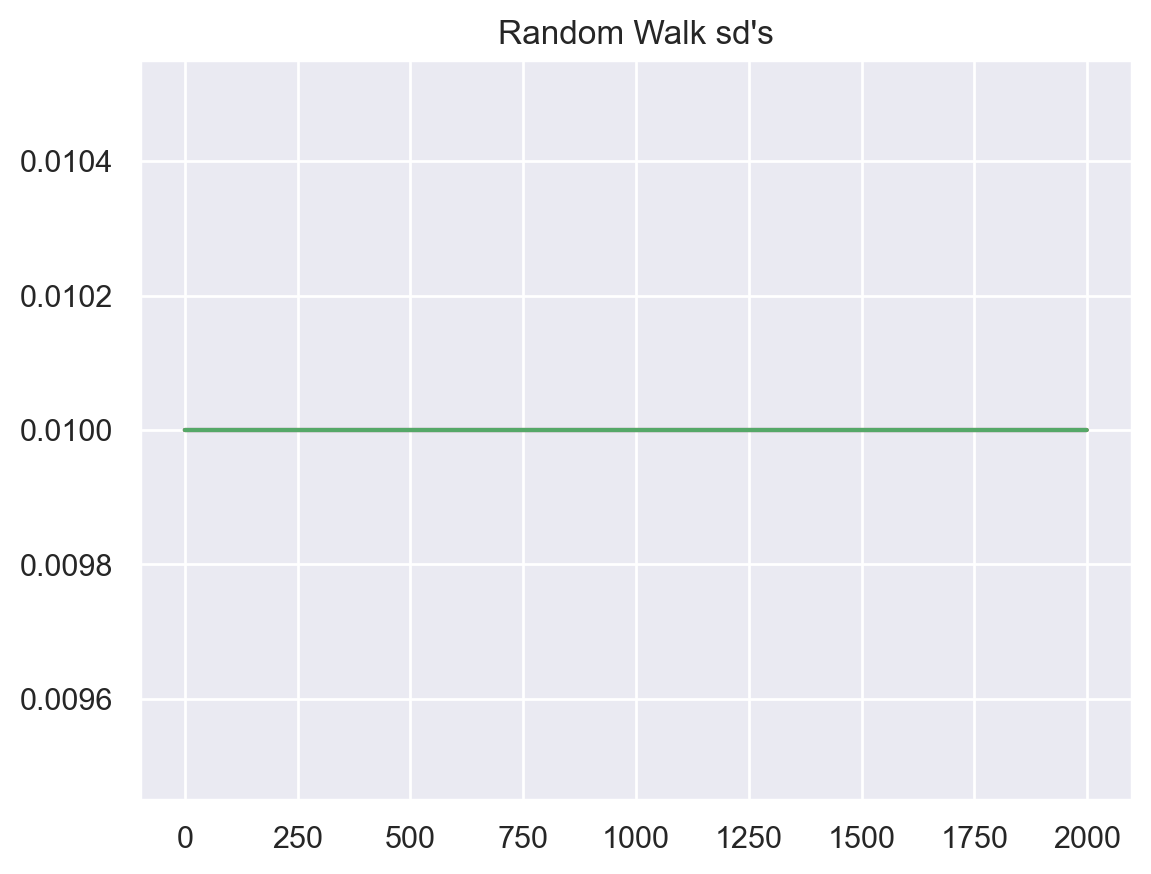

In [20]:
plt.plot(pg_out["adapt_pars"]["rw_sd"])
plt.title("Random Walk sd's");

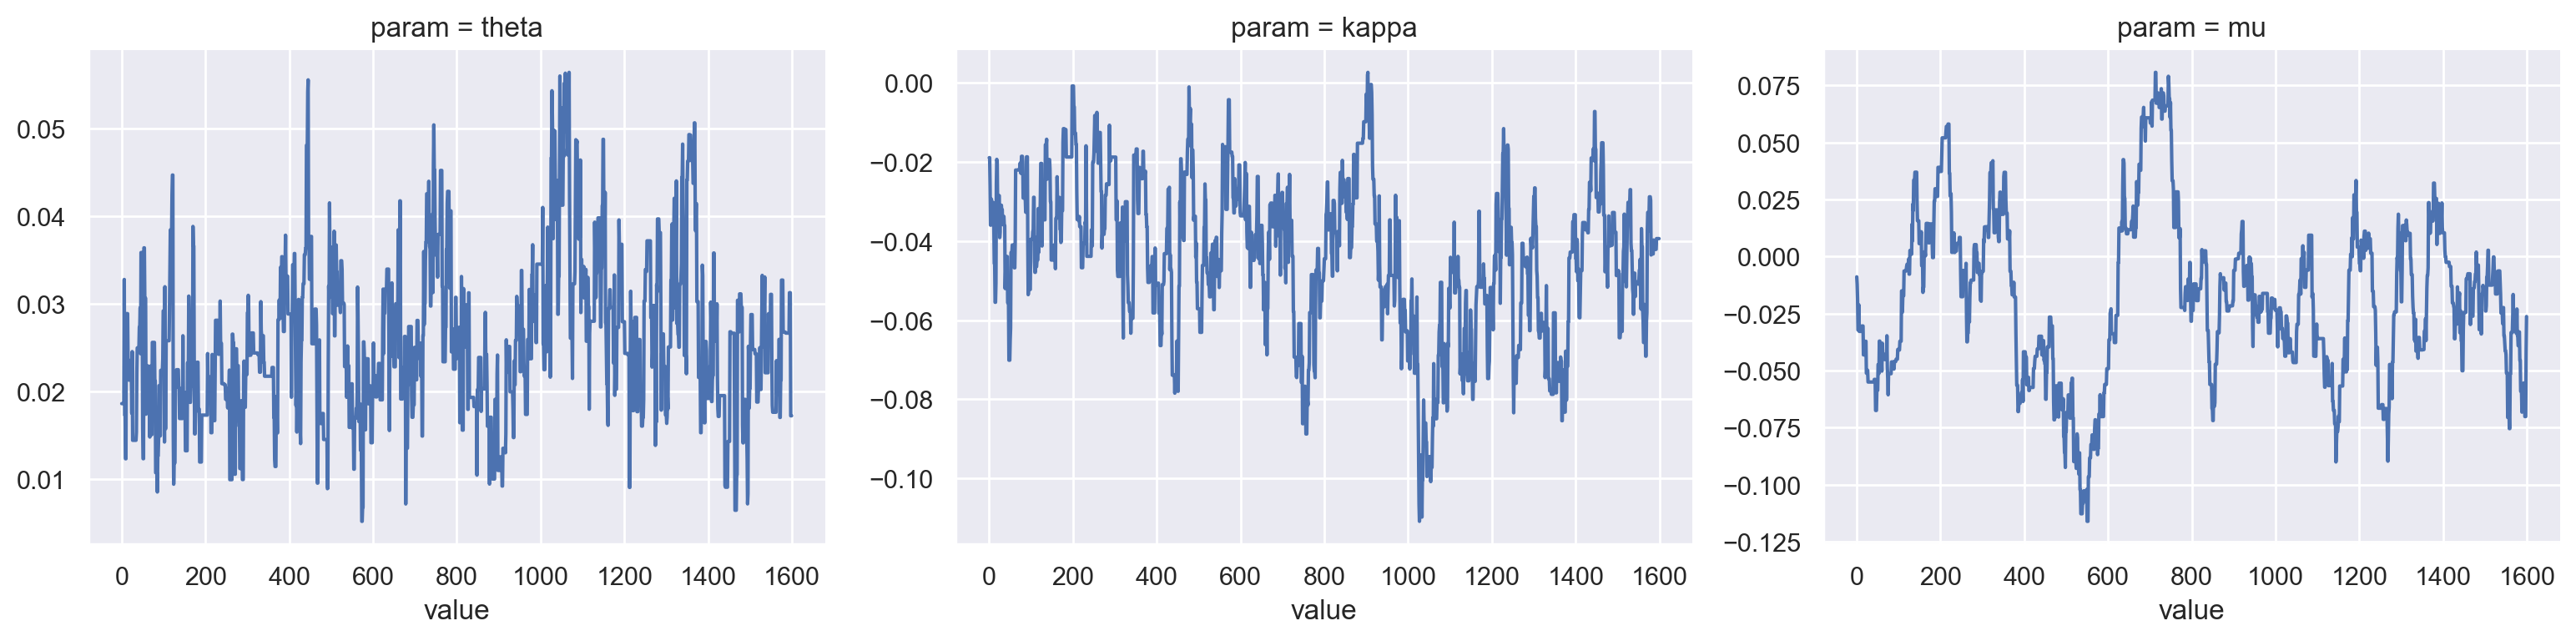

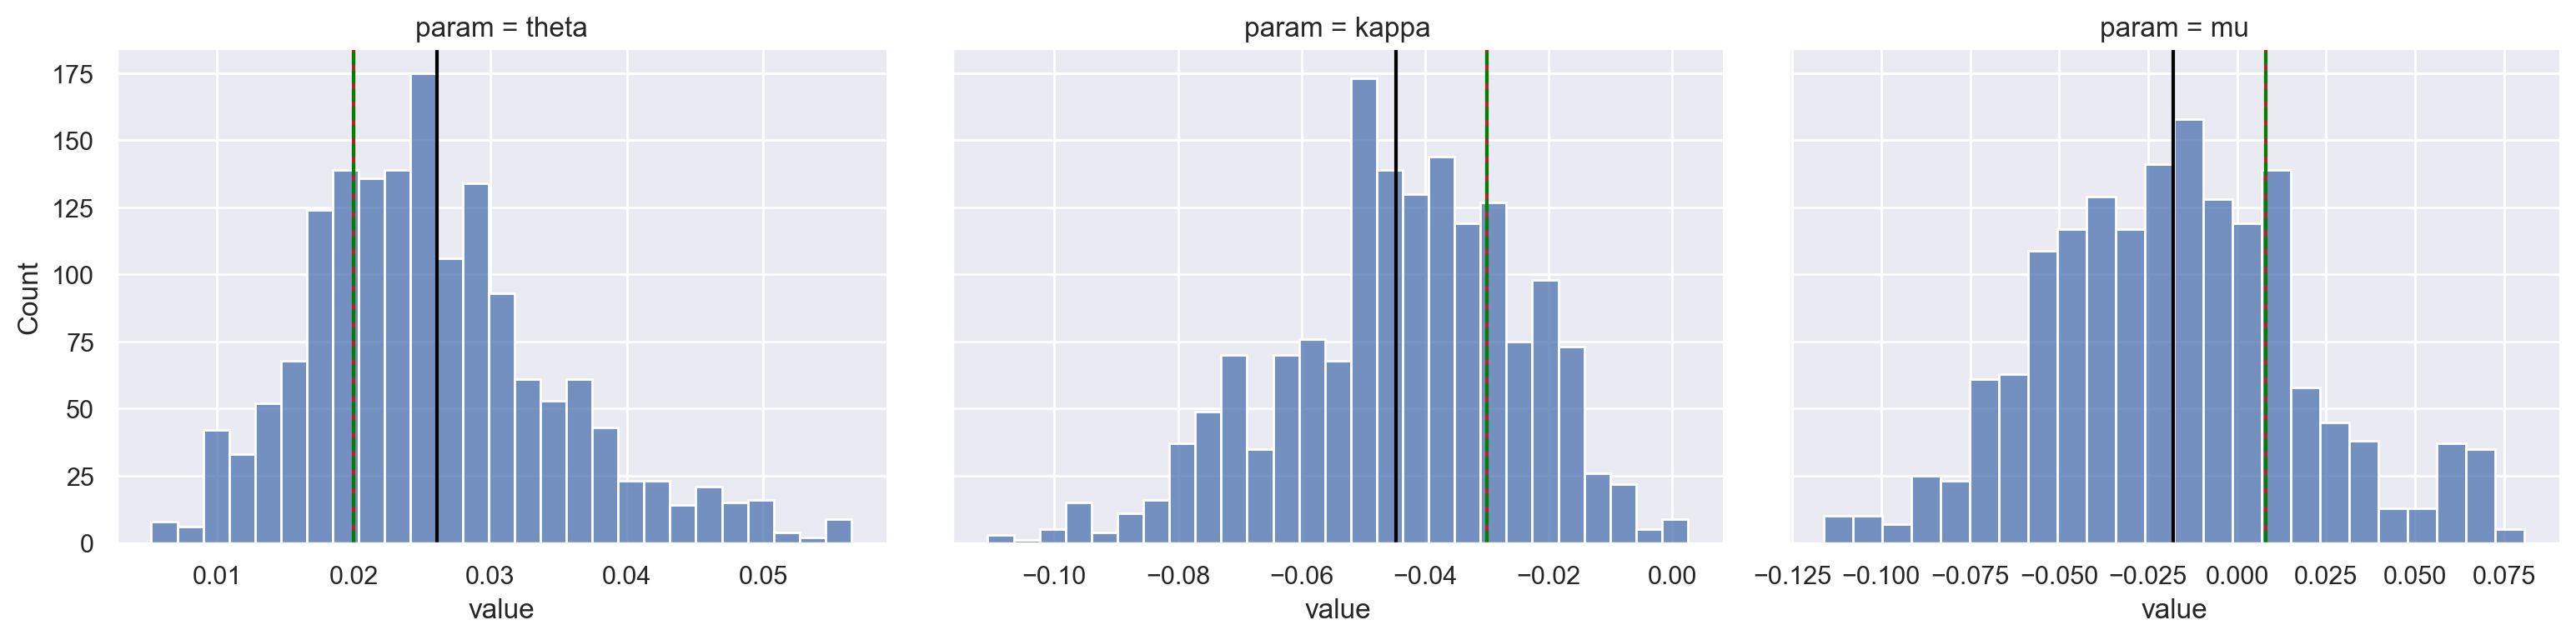

In [21]:
plot_posteriors(pg_out, theta_true=theta, theta_init=theta_init)